- Plot time-series images for each landfill and check if emissions depend on wind speed
- Pick cases to compare emission rates with Sentinel-2 RGB image

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from pystac_client import Client
import cartopy.crs as ccrs
import string
import rioxarray
import xarray as xr
from odc.stac import load

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Read data

In [3]:
data_dir = '../data/Hyper_TROPOMI_plume/'

filelist = list(chain(*[glob(os.path.join(data_dir, '**', '*csv'), recursive=True)]))

df = pd.concat((pd.read_csv(f) for f in filelist), ignore_index=True)
df['emission_uncertainty_percentage'] = df['emission_uncertainty']/df['emission']*100
# convert units from kg/h to t/h
df['emission'] /= 1e3
df['emission_uncertainty'] /= 1e3

df_emiss = df.groupby(['country', 'name'], as_index=False).agg({'emission':'mean', 'emission_uncertainty_percentage': 'mean', 'plume_id': 'count'}).rename(columns={'plume_id': 'count'})
# df_emiss = df.groupby(['country', 'name'], as_index=False).agg({'emission':'mean'})#, 'emission_uncertainty_percentage': 'mean', 'plume_id': 'count'}).rename(columns={'plume_id': 'count'})

## Wind uncertainty analysis

Text(0.5, 0, 'No. plume')

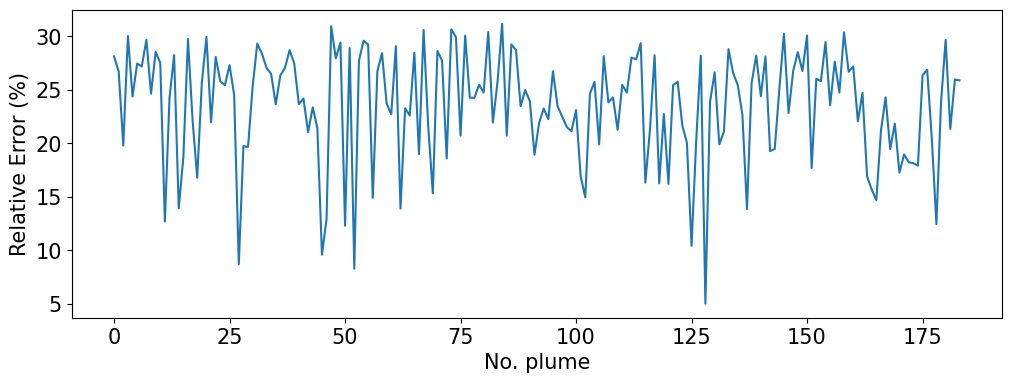

In [4]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(df['emission_uncertainty_wind']/df['emission']/1e3*1e2)
plt.ylabel('Relative Error (%)')
plt.xlabel('No. plume')

## Landfills with multiple plume OBS

In [5]:
# get landfills have multiple OBS
landfill_name_all = df_emiss[df_emiss['count']>1].sort_values(by=['count'], ascending=False)['name']

# get top 5 landfill which has multiple valid emission rates
landfill_name_tseries = df_emiss.sort_values(by=['count'], ascending=False).iloc[:5]['name']

df_tseries_all = df[df['name'].isin(landfill_name_all)]
df_tseries_all['datetime'] = pd.to_datetime(df_tseries_all['datetime'])

df_tseries = df[df['name'].isin(landfill_name_tseries)]
df_tseries['datetime'] = pd.to_datetime(df_tseries['datetime'])

/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_8326/1199488639.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tseries_all['datetime'] = pd.to_datetime(df_tseries_all['datetime'])
/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_8326/1199488639.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tseries['datetime'] = pd.to_datetime(df_tseries['datetime'])


In [6]:
# TOP 5 landfills
df_tseries['name'].drop_duplicates()

9      Seventh Ring Road
111               Riyadh
140               Dudaim
149                Tamar
162              Ghabawi
Name: name, dtype: object

### Plotting function

In [7]:
def plot_errorbar_stats(ax, df, title, color='royalblue', xaxis='datetime'):
    import matplotlib.dates as mdates

    platform_marker_dict = {'EMIT': 'royalblue', 'EnMAP': 'orange', 'PRISMA': 'gray'}
    platform_list = df['platform'].drop_duplicates().to_list()

    for platform in platform_list:
        df_platform = df[df['platform']==platform].sort_values(by=['datetime'])

        ax.errorbar(df_platform[xaxis],
                    df_platform['emission'],
                    yerr=df_platform['emission_uncertainty'],
                    marker='o', linestyle="none",
                    # c=color,
                    c=platform_marker_dict[platform],
                    # mfc=platform_marker_dict[platform],
                    capsize=3, capthick=1, label=platform)
        # plt.legend(numpoints=1)

        if xaxis == 'datetime':
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
            ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))
            # plt.xticks(rotation=45, ha='center')

        for label in ax.get_xticklabels():
            label.set_ha("center")
            label.set_rotation(45)
    
    ax.set_ylim(ymin=0)

    # ax.errorbar(df.sort_values(by=['datetime'])['datetime'],
    #             df.sort_values(by=['datetime'])['emission'],
    #             yerr=0,
    #             marker='o', c=color, markerfacecolor='none',
    #             capsize=3, capthick=1)
    ax.set_title(title)

## Landfill emission time-series

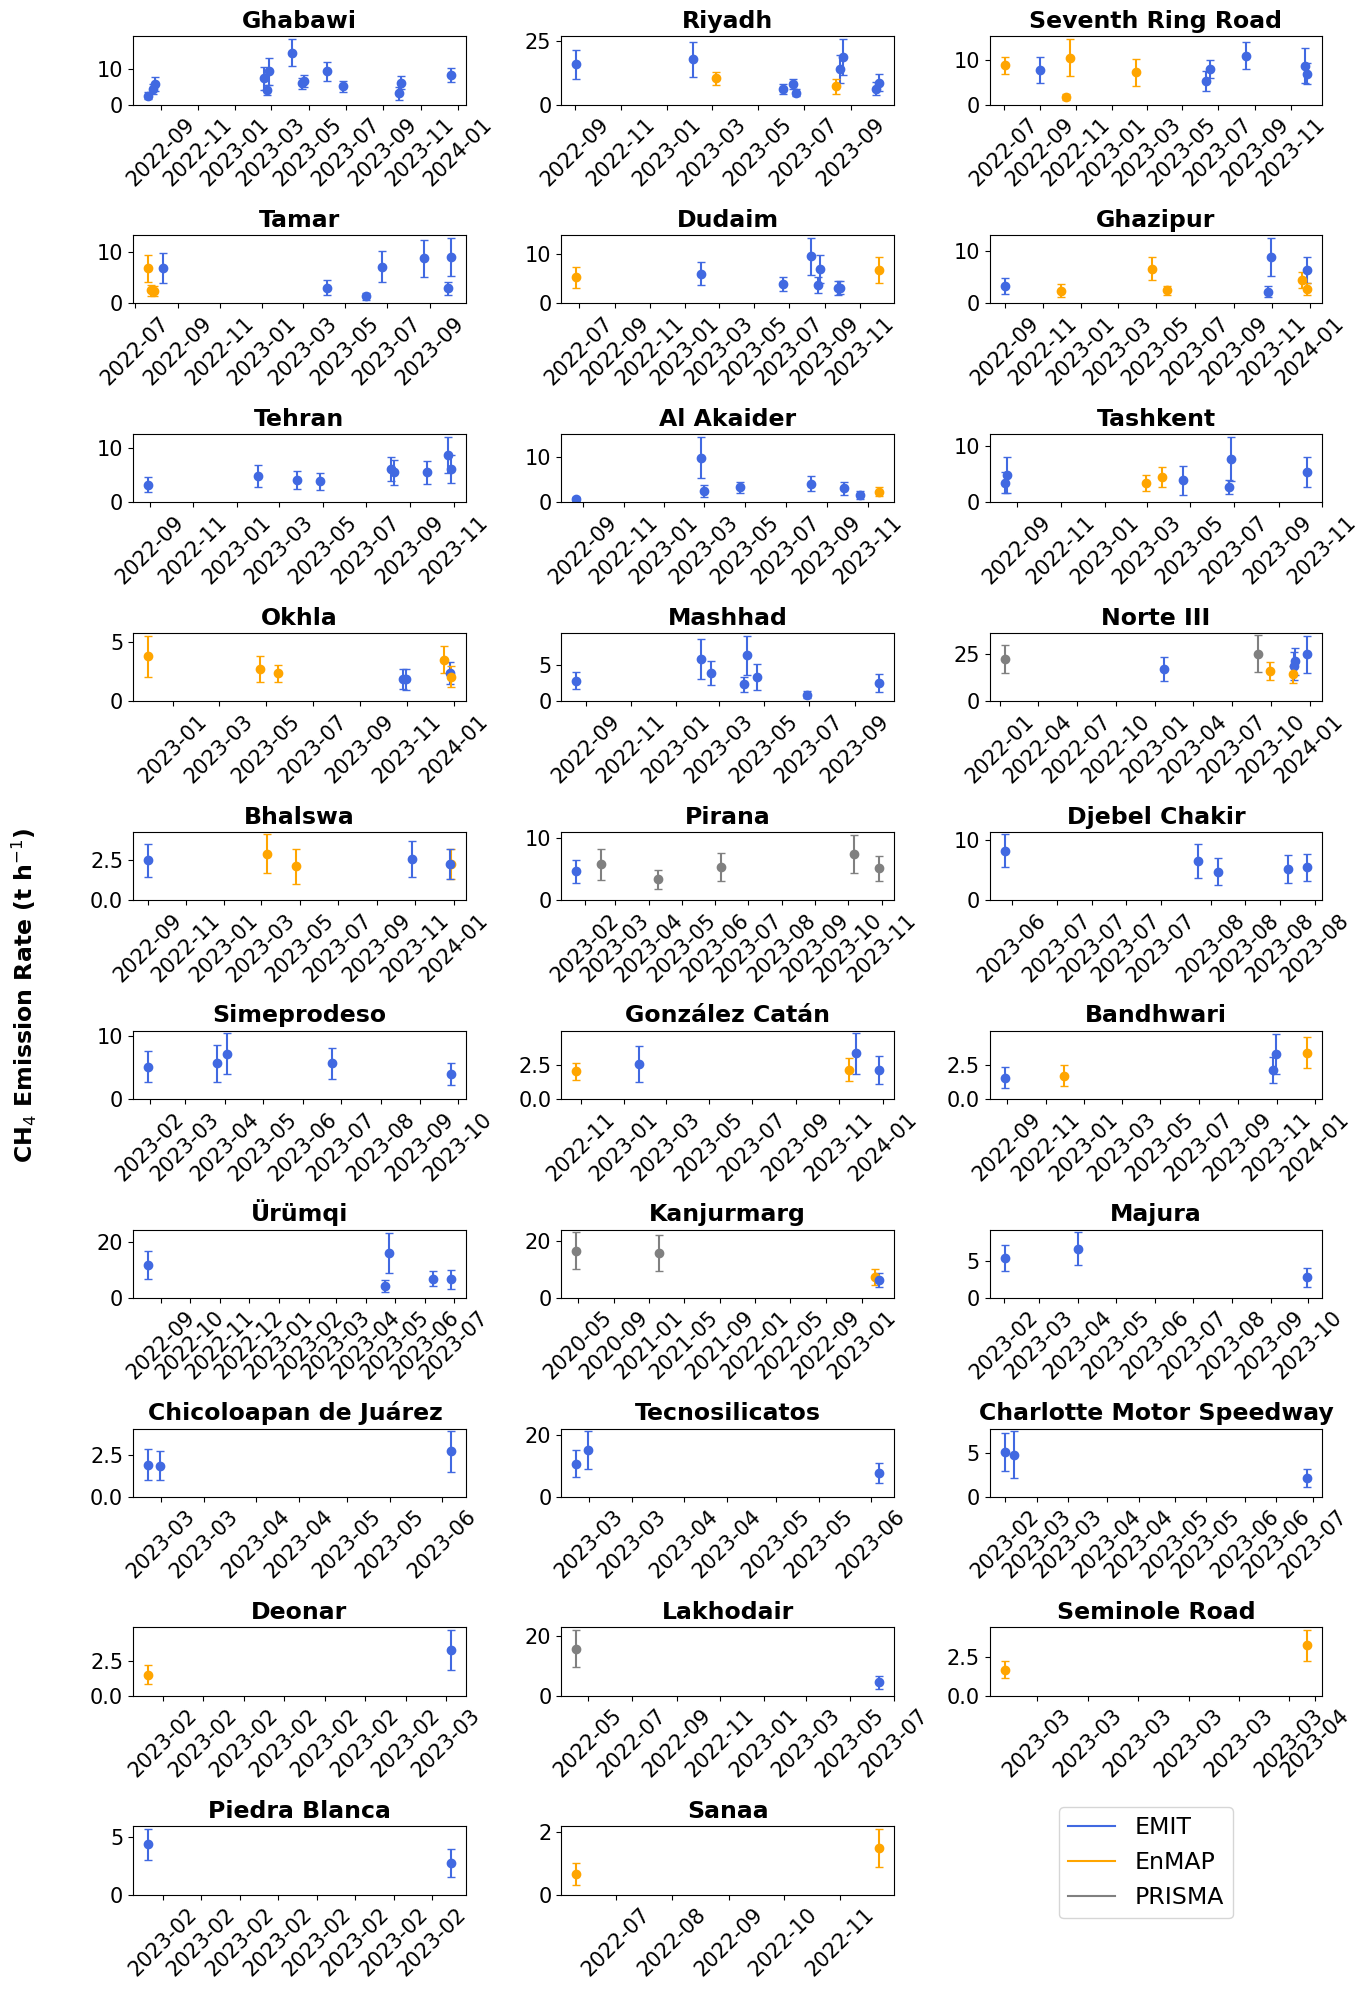

In [23]:
ncols = 3
nrows = int(np.ceil(len(landfill_name_all)/ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 20))#, sharex=True)
axs = axs.flatten()

for index,name in enumerate(landfill_name_all):
    plot_errorbar_stats(axs[index], df_tseries_all[df_tseries_all['name']==name], title=name)

fig.tight_layout()

empty_fig_num = nrows*ncols - len(landfill_name_all)
if empty_fig_num > 0:
    for i in range(empty_fig_num):
        axs[-i-1].axis('off')

fig.legend(
    loc='upper right',
    bbox_to_anchor=(0.9, 0.1),
    handles=[
        Line2D([], [], c='royalblue', label="EMIT"),
        Line2D([], [], c='orange', label="EnMAP"),
        Line2D([], [], c='gray', label="PRISMA"),
    ]
)

for ax in axs:
    ax.set_ylim(ymin=0)

# fig.text(0.5, -0.02, 'Date', ha='center', size=font_size, fontweight='bold')
fig.text(-0.05, 0.5, 'CH$_4$ Emission Rate (t h$^{-1}$)', va='center', rotation='vertical', size=font_size, fontweight='bold')

fig.tight_layout()
fig.savefig('../figures/emission_tseries_all.pdf', bbox_inches='tight')

## Relationship between emissions and wind speed

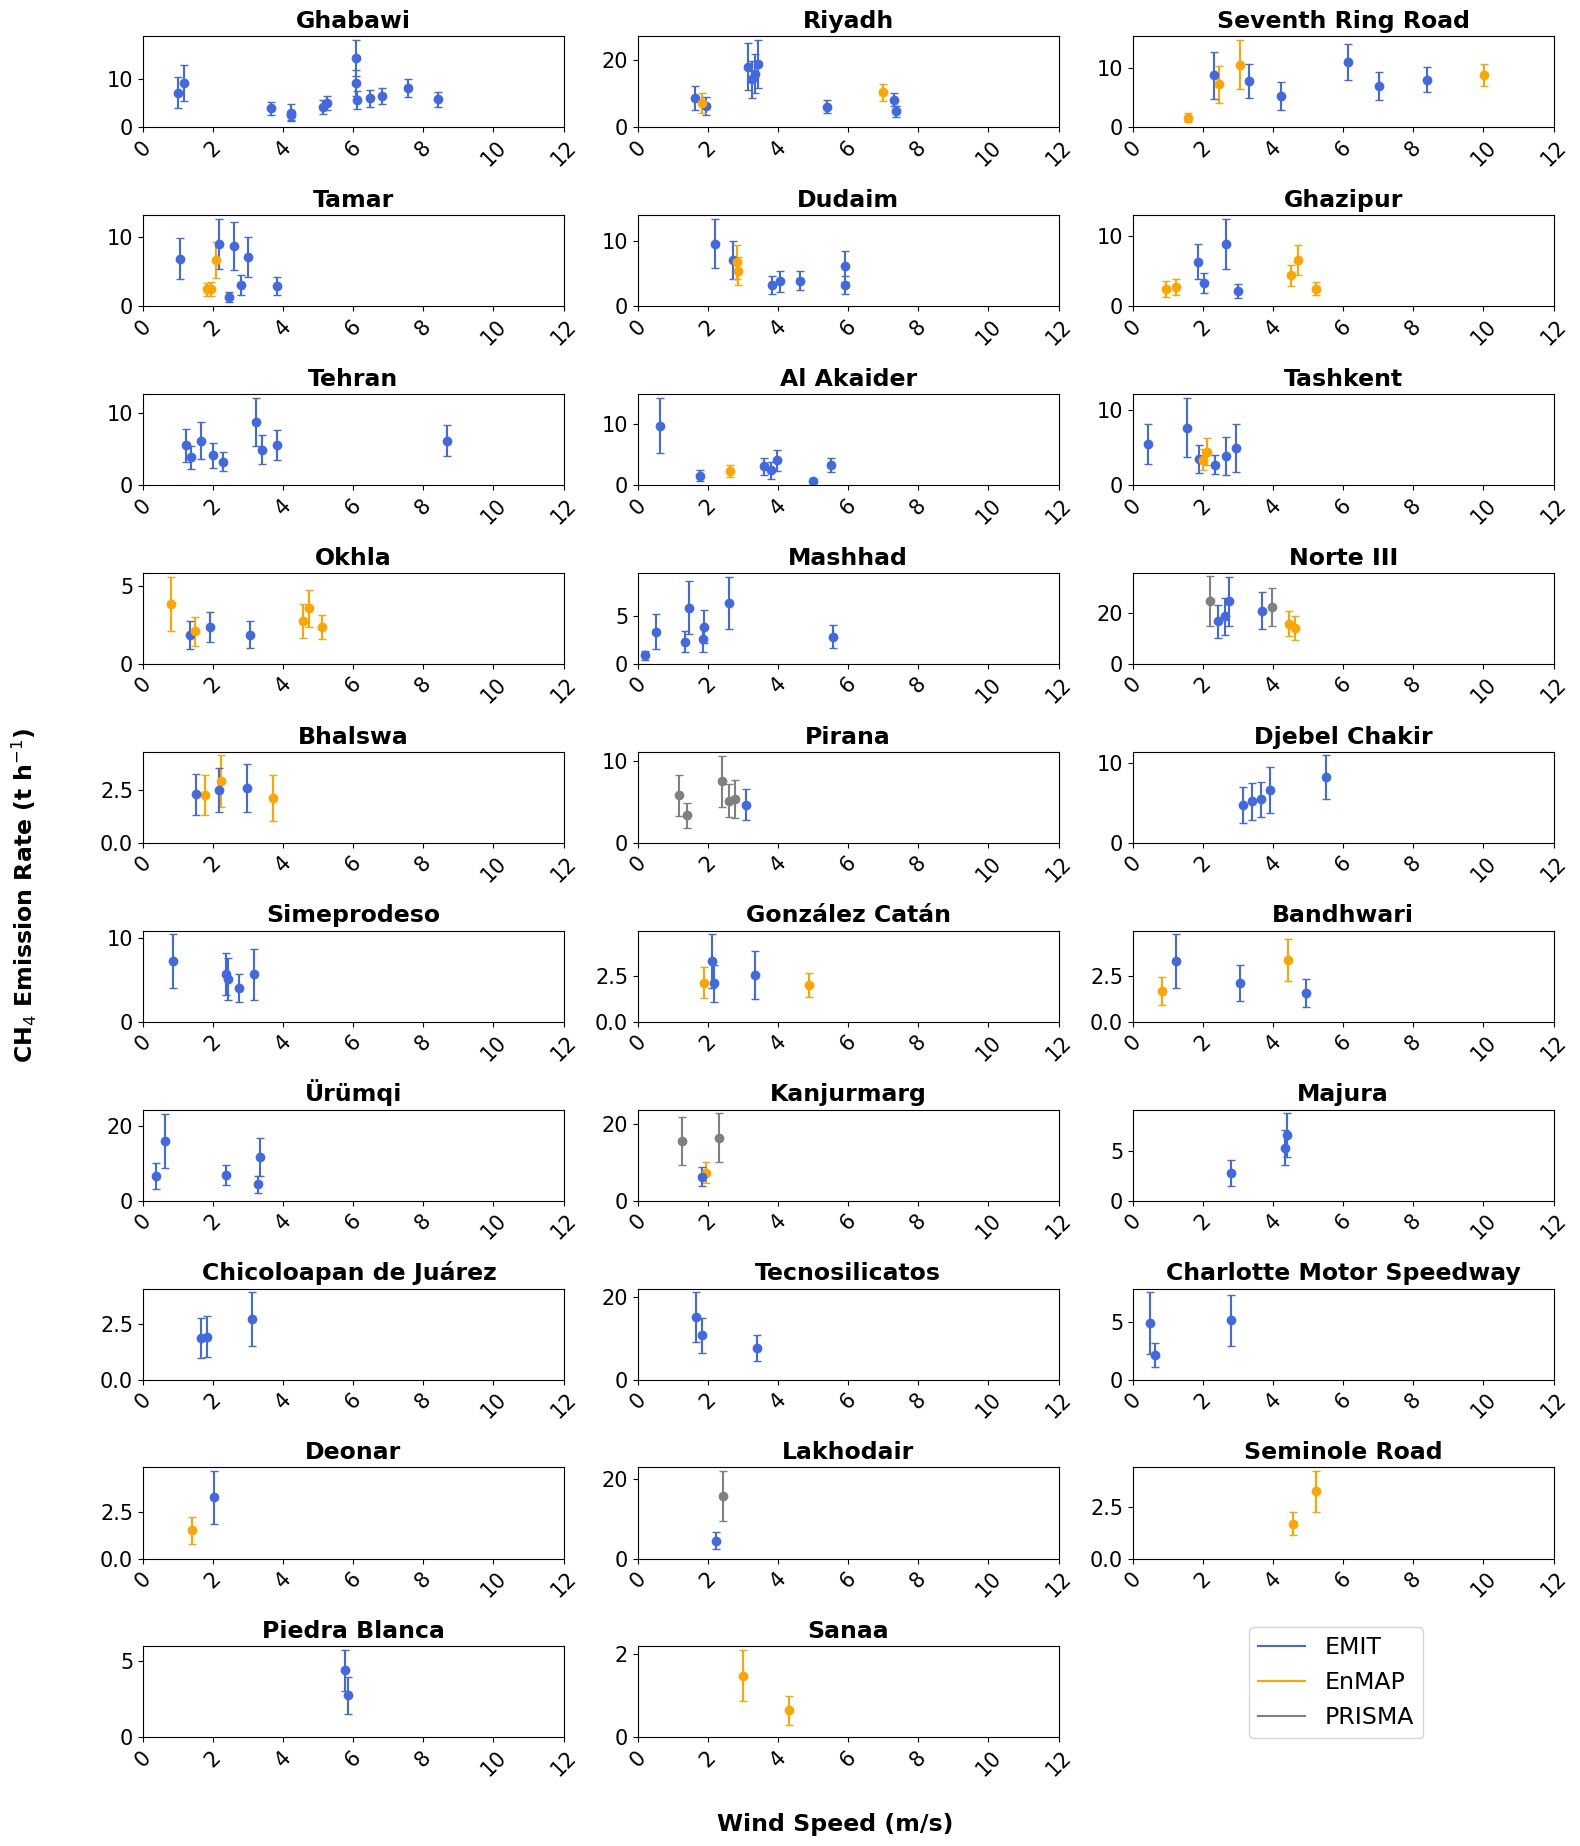

In [24]:
ncols = 3
nrows = int(np.ceil(len(landfill_name_all)/ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18))
axs = axs.flatten()

for index,name in enumerate(landfill_name_all):
    plot_errorbar_stats(axs[index], df_tseries_all[df_tseries_all['name']==name], title=name, xaxis='wind_speed')
fig.tight_layout()

empty_fig_num = nrows*ncols - len(landfill_name_all)
if empty_fig_num > 0:
    for i in range(empty_fig_num):
        axs[-i-1].axis('off')

fig.legend(
    loc='upper right',
    bbox_to_anchor=(0.9, 0.1),
    handles=[
        Line2D([], [], c='royalblue', label="EMIT"),
        Line2D([], [], c='orange', label="EnMAP"),
        Line2D([], [], c='gray', label="PRISMA"),
    ]
)

for ax in axs:
    ax.set_xlim(0, 12)
    ax.set_ylim(ymin=0)

fig.text(0.5, -0.02, 'Wind Speed (m/s)', ha='center', size=font_size, fontweight='bold')
fig.text(-0.05, 0.5, 'CH$_4$ Emission Rate (t h$^{-1}$)', va='center', rotation='vertical', size=font_size, fontweight='bold')

fig.tight_layout()
fig.savefig('../figures/emission_wspd_all.pdf', bbox_inches='tight')

## Landfill cases

### Norte III

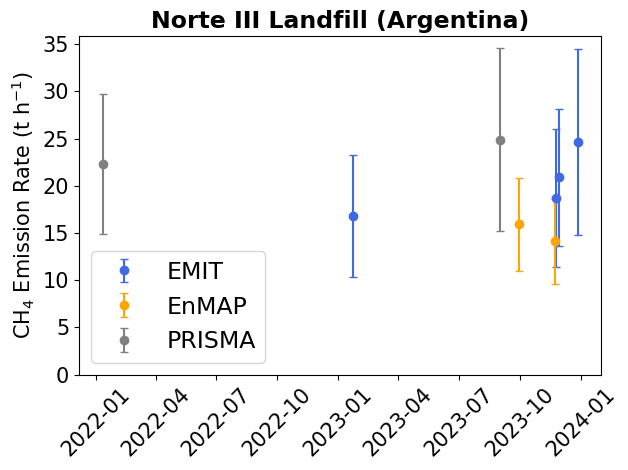

In [10]:
fig, ax = plt.subplots()

plot_errorbar_stats(ax, df_tseries_all[df_tseries_all['name']=='Norte III'], title='Norte III Landfill (Argentina)')
ax.set_ylabel('CH$_4$ Emission Rate (t h$^{-1}$)')
ax.set_xlabel('')
plt.legend(numpoints=1)

fig.tight_layout()

### Ghabawi

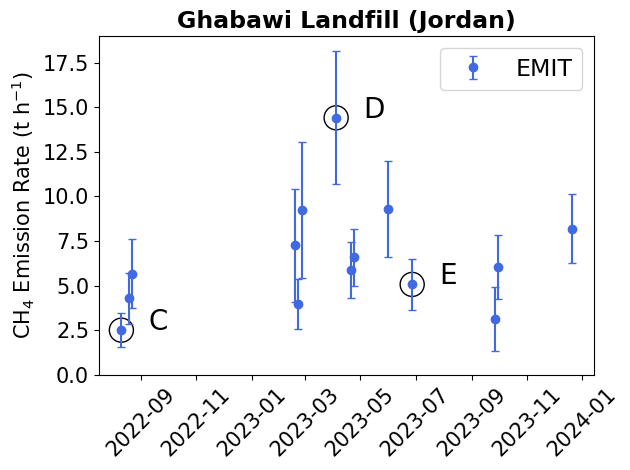

In [11]:
fig, ax = plt.subplots()

df_subset_Ghabawi = df_tseries[df_tseries['name']=='Ghabawi'].sort_values('datetime')
plot_errorbar_stats(ax, df_subset_Ghabawi, title='Ghabawi Landfill (Jordan)')
ax.set_ylabel('CH$_4$ Emission Rate (t h$^{-1}$)')
ax.set_xlabel('')
plt.legend(numpoints=1)

# first case
ax.scatter(df_subset_Ghabawi.iloc[0]['datetime'], df_subset_Ghabawi.iloc[0]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghabawi.iloc[0]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[0]['emission'], 'C', fontsize=20)

# second case
ax.scatter(df_subset_Ghabawi.iloc[6]['datetime'], df_subset_Ghabawi.iloc[6]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghabawi.iloc[6]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[6]['emission'], 'D', fontsize=20)

# third case
ax.scatter(df_subset_Ghabawi.iloc[-4]['datetime'], df_subset_Ghabawi.iloc[-4]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghabawi.iloc[-4]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[-4]['emission'], 'E', fontsize=20)


fig.tight_layout()

### Ghazipur

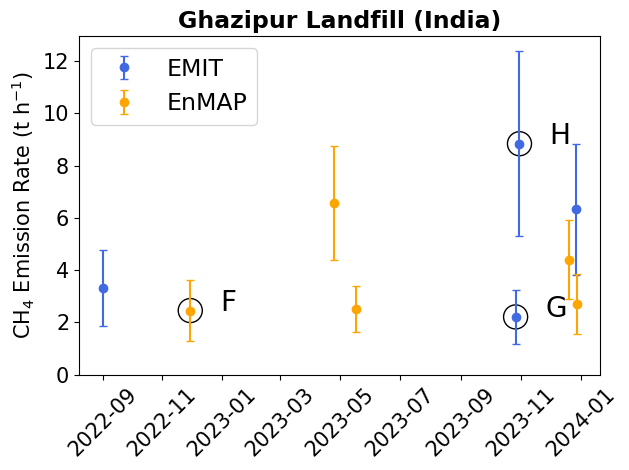

In [12]:
fig, ax = plt.subplots()

df_subset_Ghazipur = df_tseries_all[df_tseries_all['name']=='Ghazipur'].sort_values('datetime')
plot_errorbar_stats(ax, df_subset_Ghazipur, title='Ghazipur Landfill (India)')
ax.set_ylabel('CH$_4$ Emission Rate (t h$^{-1}$)')
ax.set_xlabel('')
plt.legend(numpoints=1)

# first case
ax.scatter(df_subset_Ghazipur.iloc[1]['datetime'], df_subset_Ghazipur.iloc[1]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghazipur.iloc[1]['datetime']+pd.Timedelta(days=30), df_subset_Ghazipur.iloc[1]['emission'], 'F', fontsize=20)

# second case
ax.scatter(df_subset_Ghazipur.iloc[4]['datetime'], df_subset_Ghazipur.iloc[4]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghazipur.iloc[4]['datetime']+pd.Timedelta(days=30), df_subset_Ghazipur.iloc[4]['emission'], 'G', fontsize=20)

# third case
ax.scatter(df_subset_Ghazipur.iloc[5]['datetime'], df_subset_Ghazipur.iloc[5]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghazipur.iloc[5]['datetime']+pd.Timedelta(days=30), df_subset_Ghazipur.iloc[5]['emission'], 'H', fontsize=20)


fig.tight_layout()


## Sentinel-2 images

### Plotting functions

In [13]:
client = Client.open("https://earth-search.aws.element84.com/v1")
collection = "sentinel-2-l2a"

def get_img(row, bbox, buffer=0.01):
    # search 5 days
    st = (row['datetime'] - pd.Timedelta(days=2)).strftime('%Y-%m-%d')
    et = (row['datetime'] + pd.Timedelta(days=2)).strftime('%Y-%m-%d')

    # point = Point(row['plume_longitude'], row['plume_latitude'])
    # # add the required distance/buffer around the lat lon
    # bbox = point.buffer(buffer).bounds

    # get one clear image in 2023
    search = client.search(collections = [collection],
                            bbox = bbox,
                            datetime = f'{st}/{et}',
                            # query = {"eo:cloud_cover":{"lt":0.1}},
                            # max_items=1,
                            )
    data = load(search.items(), bbox=bbox, groupby="solar_day", chunks={})
    img = data[["red", "green", "blue"]].to_array().rename('rgb')

    img = img.sel(time=row['datetime'], method='nearest')

    return img

def plot_s2(ax, img):
    img = img.rio.reproject('EPSG:4326')
    img = img.where(img!=img.rio.nodata)
    img.plot.imshow(ax=ax, robust=True, rasterized=True)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title('')
    # ax.set_title(img.time.dt.strftime('%Y-%m-%d').item())

In [14]:
def plot_case(axs, row, num, data_dir, pad=0.01):
    '''
    row: Series
    num: A,B, C index
    data_dir: where plume NC files are saved
    '''
    # set extent
    lon_min = row['plume_longitude'] - pad
    lon_max = row['plume_longitude'] + pad
    lat_min = row['plume_latitude'] - pad
    lat_max = row['plume_latitude'] + pad

    ax = axs[0]
    ax.set_extent((lon_min, lon_max, lat_min, lat_max))

    img = get_img(row, bbox=(lon_min, lat_min, lon_max, lat_max))
    plot_s2(ax, img)

    ax = axs[1]
    l3_filename = glob(f'{data_dir}/*'+row['plume_id'].upper().split('-')[1]+'*.nc')[0]

    print(l3_filename)
    ds = xr.open_dataset(l3_filename)
    ch4_plume = ds['ch4'].dropna(dim='x', how='all').dropna(dim='y', how='all')

    plot_s2(ax, img)

    m = ch4_plume.plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=300, cmap='plasma', add_colorbar=False, rasterized=True)

    # ax.set_title(ch4_plume.attrs['start_time'][:10])
    ax.set_title('')
    ax.set_extent((lon_min, lon_max, lat_min, lat_max))

    for ax in axs:
        ax.text(0.02, 0.86, string.ascii_uppercase[num],
                transform=ax.transAxes, 
                size=20, weight='bold', c='w')
    return m

/Users/xinz/miniconda3/envs/hyperch4/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


../data/tseries/Ghabawi/EMIT_L3B_001_20220818T114440_2223008_004_plume0.nc
../data/tseries/Ghabawi/EMIT_L3B_001_20230404T085908_2309406_041_plume0.nc
../data/tseries/Ghabawi/EMIT_L3B_001_20230627T075201_2317805_006_plume0.nc
../data/tseries/Ghazipur/ENMAP01-____L3B-DT0000005567_20221129T061707Z_003_V010201_20230426T040352Z_plume0.nc
../data/tseries/Ghazipur/ENMAP01-____L3B-DT0000017846_20230517T055824Z_001_V010301_20230614T112945Z_plume0.nc
../data/tseries/Ghazipur/EMIT_L3B_001_20231030T035545_2330303_006_plume0.nc


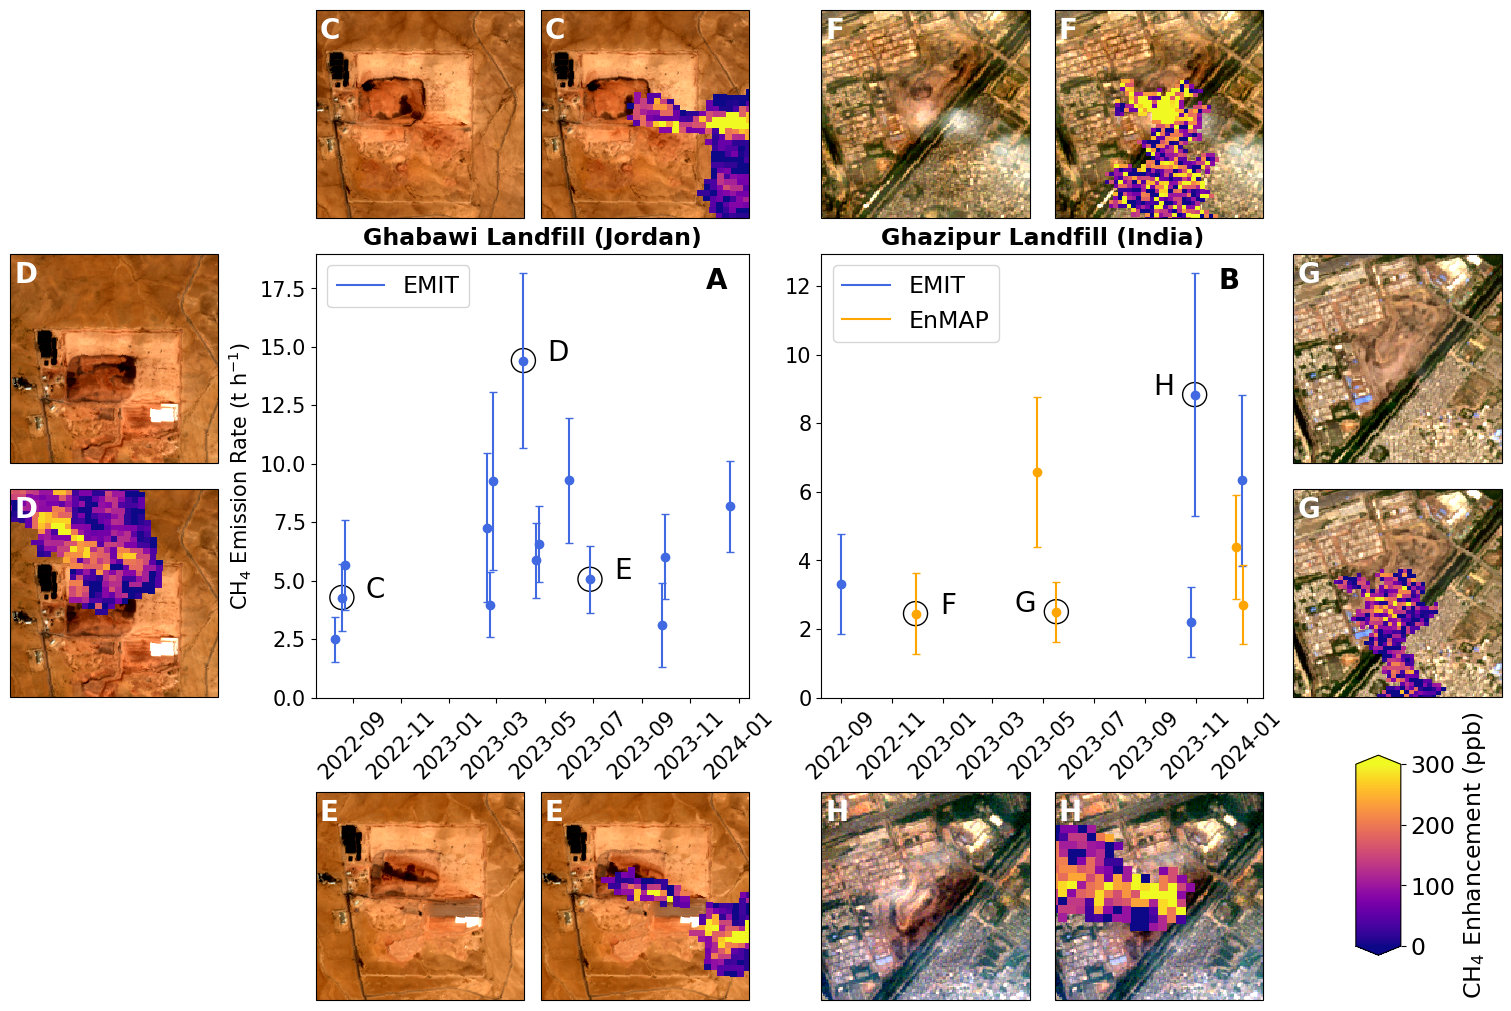

In [15]:
a = list(map(str, range(18)))
axis_proj = tuple(filter(lambda v: v not in ['0', '8', '9'], a))

fig, axs = plt.subplot_mosaic([['1', '2', '3', '4', '5', '6'],
                               ['7', '8', '8', '9', '9', '10'],
                               ['11', '8', '8', '9', '9', '12'],
                               ['13', '14', '15', '16', '17', '18']
                               ],
                               per_subplot_kw={axis_proj: {"projection": ccrs.PlateCarree()}},
                               figsize=(15, 10),
                               constrained_layout=True,
                               )


# --- time series ---
ax = axs['8']
df_subset_Ghabawi = df_tseries[df_tseries['name']=='Ghabawi'].sort_values('datetime')
plot_errorbar_stats(ax, df_subset_Ghabawi, title='Ghabawi Landfill (Jordan)')
ax.set_ylabel('CH$_4$ Emission Rate (t h$^{-1}$)')

# first case
ax.scatter(df_subset_Ghabawi.iloc[1]['datetime'], df_subset_Ghabawi.iloc[1]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghabawi.iloc[1]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[1]['emission'], 'C', fontsize=20)

# second case
ax.scatter(df_subset_Ghabawi.iloc[6]['datetime'], df_subset_Ghabawi.iloc[6]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghabawi.iloc[6]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[6]['emission'], 'D', fontsize=20)

# third case
ax.scatter(df_subset_Ghabawi.iloc[-4]['datetime'], df_subset_Ghabawi.iloc[-4]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghabawi.iloc[-4]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[-4]['emission'], 'E', fontsize=20)

ax.text(0.9, 0.92, string.ascii_uppercase[0],
        transform=ax.transAxes, 
        size=20, weight='bold')

# --- time series ---

ax = axs['9']
df_subset_Ghazipur = df_tseries_all[df_tseries_all['name']=='Ghazipur'].sort_values('datetime')
plot_errorbar_stats(ax, df_subset_Ghazipur, title='Ghazipur Landfill (India)')

# first case
ax.scatter(df_subset_Ghazipur.iloc[1]['datetime'], df_subset_Ghazipur.iloc[1]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghazipur.iloc[1]['datetime']+pd.Timedelta(days=30), df_subset_Ghazipur.iloc[1]['emission'], 'F', fontsize=20)

# second case
ax.scatter(df_subset_Ghazipur.iloc[3]['datetime'], df_subset_Ghazipur.iloc[3]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghazipur.iloc[3]['datetime']-pd.Timedelta(days=50), df_subset_Ghazipur.iloc[3]['emission'], 'G', fontsize=20)

# third case
ax.scatter(df_subset_Ghazipur.iloc[-4]['datetime'], df_subset_Ghazipur.iloc[-4]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghazipur.iloc[-4]['datetime']-pd.Timedelta(days=50), df_subset_Ghazipur.iloc[-4]['emission'], 'H', fontsize=20)

ax.text(0.9, 0.92, string.ascii_uppercase[1],
        transform=ax.transAxes, 
        size=20, weight='bold')


# -- Ghabawi cases --
plot_case([axs['2'], axs['3']], df_subset_Ghabawi.iloc[1], num=2, data_dir='../data/tseries/Ghabawi')
plot_case([axs['7'], axs['11']], df_subset_Ghabawi.iloc[6], num=3, data_dir='../data/tseries/Ghabawi')
plot_case([axs['14'], axs['15']], df_subset_Ghabawi.iloc[-4], num=4, data_dir='../data/tseries/Ghabawi')

# -- Ghazipur cases --
plot_case([axs['4'], axs['5']], df_subset_Ghazipur.iloc[1], num=5, data_dir='../data/tseries/Ghazipur', pad=0.007)
plot_case([axs['10'], axs['12']], df_subset_Ghazipur.iloc[3], num=6, data_dir='../data/tseries/Ghazipur', pad=0.007)
m = plot_case([axs['16'], axs['17']], df_subset_Ghazipur.iloc[-4], num=7, data_dir='../data/tseries/Ghazipur', pad=0.007)

for ax in [axs['1'], axs['6'], axs['13'], axs['18']]:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_axis_off()


axs['8'].legend(
    loc='upper left',
    handles=[
        Line2D([], [], c='royalblue', label="EMIT"),
    ]
)

axs['9'].legend(
    loc='upper left',
    # bbox_to_anchor=(0.95, 0.1),
    handles=[
        Line2D([], [], c='royalblue', label="EMIT"),
        Line2D([], [], c='orange', label="EnMAP"),
    ]
)

# add colorbar
cax = fig.add_axes([0.9, 0.05, 0.03, 0.2])
cb = fig.colorbar(m, cax=cax, extend='both', orientation="vertical")
cb.ax.tick_params(labelsize=17)
cb.ax.set_ylabel('CH$_4$ Enhancement (ppb)', fontsize=17)

fig.savefig('../figures/tseries.pdf')